In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.sql import Row
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics

In [3]:
sc = SparkContext("local", "First App")

pd.options.mode.chained_assignment = None 
pd.options.display.max_columns = 100

In [4]:
spark = SparkSession.builder.appName('visualization').getOrCreate()

In [6]:
items = spark.read.parquet('model_trained/itemFactors')

In [7]:
genres = spark.read.parquet('03_extension_visuals/with_genres.parquet').withColumnRenamed("track_id_int", "id")

In [8]:
items.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[0.12977862, -0.0...|
| 10|[0.0585568, 0.032...|
| 20|[0.075312465, -0....|
| 30|[-0.11600768, -0....|
| 40|[0.15276441, -0.0...|
+---+--------------------+
only showing top 5 rows



In [9]:
genres.show(5)

+------------------+-------+----------+
|          track_id|     id|     genre|
+------------------+-------+----------+
|TRBHUNB12903D080AF| 2440.0|  Pop_Rock|
|TRQUJJJ128F93450B9|  174.0|  Pop_Rock|
|TRSSGDG128F932D184|57453.0|Electronic|
|TRMTKWY128E0785C59| 1651.0|  Pop_Rock|
|TRRONNI128F428EFEB|47853.0|  Pop_Rock|
+------------------+-------+----------+
only showing top 5 rows



In [10]:
merged = items.join(genres, on = 'id', how = 'inner')

In [11]:
merged.show(5)

+----+--------------------+------------------+--------+
|  id|            features|          track_id|   genre|
+----+--------------------+------------------+--------+
| 558|[-0.09859555, -0....|TRNPSSM128F4243517|Pop_Rock|
| 596|[0.02247643, -0.0...|TRFAWKX12903CE30F4| Country|
|1761|[-0.0031012755, 0...|TRWAXPQ128F93450CE|Pop_Rock|
|2815|[0.014360283, -0....|TRQDOLT128F1465260|Pop_Rock|
|3597|[-0.0035676823, -...|TRHJTXQ12903D0827B|Pop_Rock|
+----+--------------------+------------------+--------+
only showing top 5 rows



In [12]:
items.count()

385371

In [13]:
genres.count()

87675

In [14]:
merged.count()

87675

In [16]:
merged_df = merged.toPandas().set_index('id')

In [17]:
features = pd.DataFrame(merged_df.features.to_list(), index = merged_df.index)

In [19]:
genres_df = pd.DataFrame(merged_df.genre, index= merged_df.index)

In [20]:
features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
558,-9.859555e-02,-0.005292,-0.078220,0.036849,0.046599,-0.025477,-0.087164,0.097757,0.035272,-0.045373,0.047402,0.054577,-0.059768,0.072066,-0.038383,0.013442,-3.063016e-02,0.000312,-0.017167,0.042252,-0.047307,-0.014371,0.012609,0.089622,5.446626e-02,0.075723,0.021591,-0.043754,8.658049e-02,0.159887,-0.066577,-0.140274,0.073734,-0.036187,-0.020579,0.041712,-0.037498,0.029926,0.020041,-0.049881,-0.017809,-0.049534,0.009334,0.055089,0.033270,-0.009782,0.018186,0.033341,-0.105505,-0.005895,-0.001977,0.025035,0.024698,-0.008128,0.082490,-0.005364,0.016803,0.050153,0.099147,0.047785,0.019585,0.043073,0.026646,0.022090,-0.011148,0.036500,-0.002681,-0.039135,-0.044058,0.065284,-0.091642,0.070674,-0.023266,-0.018664,-0.033658,0.007711,-0.028361,-0.005371,-0.036782,0.037825,0.063916,-3.141275e-02,0.087009,-0.006193,-0.046711,-0.002355,0.000771,-0.033878,0.007931,0.029787,0.004636,0.007454,0.059667,0.053780,-0.072196,0.015557,-0.038638,-0.053276,0.047463,-0.022522
596,2.247643e-02,-0.068849,-0.001849,-0.070960,0.048696,-0.038539,0.047612,-0.010682,-0.084079,0.075031,-0.086894,0.011978,0.101975,-0.000039,-0.056132,-0.001681,-1.986093e-02,-0.049840,-0.065895,-0.030443,-0.034228,-0.029296,-0.013208,0.032729,-4.136512e-02,0.046479,-0.006064,0.025823,3.951553e-03,0.079812,0.056673,0.014574,-0.000949,0.071583,0.043856,0.042445,-0.054251,-0.003091,-0.038369,0.011869,0.020457,-0.028327,0.022632,-0.030687,-0.046793,-0.103861,-0.000266,0.016815,-0.014847,0.136920,-0.002109,-0.052975,-0.015677,-0.005759,-0.032223,0.035689,-0.009492,0.098071,-0.011844,-0.019301,0.010290,-0.003660,-0.089482,-0.018669,0.087895,0.079745,-0.016789,0.081834,-0.052948,-0.028042,-0.084840,0.012251,-0.041655,-0.028265,-0.003631,0.040626,-0.010839,-0.029786,0.071833,-0.048355,0.128216,2.699233e-02,-0.014709,-0.112763,0.066940,-0.094174,0.030203,-0.025594,0.033204,-0.001253,-0.004846,0.014755,0.157805,-0.019999,0.009863,0.063245,-0.063906,0.020769,-0.025200,-0.059522
1761,-3.101276e-03,0.055429,-0.023772,-0.015656,0.022822,-0.023500,-0.011834,0.022299,-0.001652,-0.037852,0.003285,-0.035423,-0.025351,-0.026468,0.128127,0.064236,2.128917e-02,-0.043494,0.033827,0.086524,0.036806,0.019066,0.084558,-0.000892,-3.869370e-02,-0.106286,0.018969,-0.009890,-6.711330e-02,0.030290,-0.021860,0.006232,-0.064112,-0.025945,-0.033209,0.013661,-0.001083,-0.039050,0.019126,-0.011587,0.042373,-0.002422,0.047572,-0.021263,-0.001791,0.051401,0.036848,0.076345,0.004478,0.002671,-0.075731,-0.039423,0.042214,0.009790,-0.003646,0.026074,-0.008379,-0.024739,0.008996,-0.053424,0.047177,0.004067,0.002366,0.002771,0.007323,0.066108,0.048422,0.012091,-0.078279,0.044126,-0.023692,-0.013725,-0.030140,-0.049243,0.082997,-0.043738,0.049043,-0.035631,-0.010411,0.080670,-0.006698,-1.679777e-03,0.001270,-0.023783,0.030987,-0.034565,-0.014614,-0.027435,-0.017679,-0.113765,-0.015282,0.001167,-0.021340,-0.037082,-0.000396,0.016283,0.032910,0.028107,0.026755,-0.003282
2815,1.436028e-02,-0.046756,-0.011033,-0.032295,0.016422,-0.013891,0.072573,-0.027273,-0.006957,0.019161,-0.039560,0.038565,0.058321,0.000892,-0.011200,0.061085,-3.519474e-02,-0.017969,0.055849,0.057890,-0.006427,0.054509,-0.063608,0.004722,2.294290e-02,0.046656,-0.075171,-0.000925,-3.961383e-02,0.028300,0.006767,0.003914,0.016899,0.038130,-0.024164,-0.031464,0.005445,0.001620,-0.035418,-0.035004,-0.028637,0.066891,0.031826,0.067138,-0.003775,0.079088,-0.007382,0.021879,0.041148,0.069091,-0.012395,0.043484,0.009210,-0.000512,0.011310,0.049564,-0.008798,0.067017,0.005558,0.056567,-0.000122,0.015636,0.057425,-0.041517,0.018065,-0.009326,-0.034569,0.014547,-0.033094,-

In [21]:
genres_df

,genre
id,
558,Pop_Rock
596,Country
1761,Pop_Rock
2815,Pop_Rock
3597,Pop_Rock
...,...
377136,Pop_Rock
377370,Pop_Rock
378078,Pop_Rock


In [22]:
data = np.array(features)

In [29]:
labels = np.array(genres_df).reshape(-1)

In [70]:
import umap
import umap.plot

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0, metric='cosine',
     min_dist=0.0001, n_neighbors=200, random_state=66, spread=1, verbose=True)
Construct fuzzy simplicial set
Mon May 17 16:23:51 2021 Finding Nearest Neighbors
Mon May 17 16:23:51 2021 Building RP forest with 20 trees
Mon May 17 16:23:52 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Mon May 17 16:27:25 2021 Finished Nearest Neighbor Search
Mon May 17 16:27:30 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon May 17 16:30:19 2021 Finished embedding


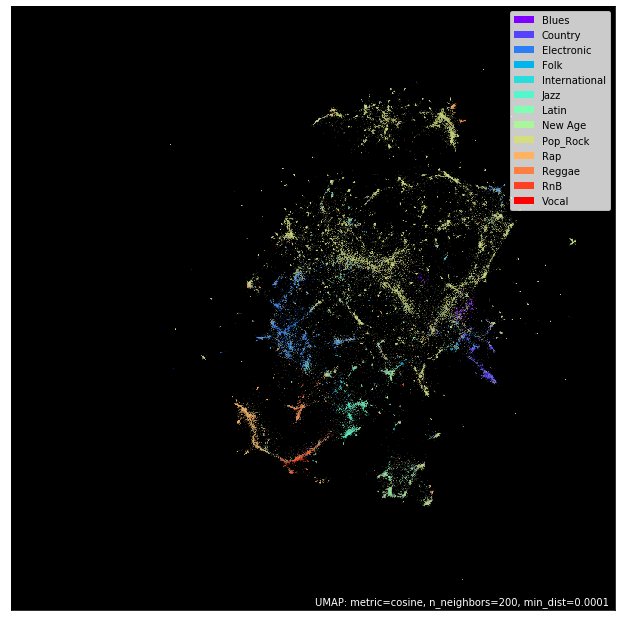

In [60]:
mapper = umap.UMAP(random_state=66, n_components=2, verbose = True, n_neighbors=200, spread = 1, min_dist = 0.0001, metric = 'cosine').fit(data)
umap.plot.points(mapper, labels = labels, theme='fire')